In [1]:
import math, random, itertools, heapq, statistics, time
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt  # bez seaborn

In [2]:
# graf i najkraci putevi
class UndirectedGraph:
    def __init__(self, n: int):
        self.n = n
        self.adj = [[] for _ in range(n)]
        self.edges = []          # (u,v,w), u<v
        self.edge_endpoints = []
        self.edge_w = []

    def add_edge(self, u: int, v: int, w: float):
        if v < u: u, v = v, u
        eid = len(self.edges)
        self.edges.append((u, v, w))
        self.edge_endpoints.append((u, v))
        self.edge_w.append(w)
        self.adj[u].append((v, w, eid))
        self.adj[v].append((u, w, eid))

    def dijkstra(self, s: int):
        dist = [math.inf]*self.n
        prev = [-1]*self.n
        dist[s] = 0.0
        pq = [(0.0, s)]
        while pq:
            d, u = heapq.heappop(pq)
            if d != dist[u]: continue
            for v, w, _eid in self.adj[u]:
                nd = d + w
                if nd < dist[v]:
                    dist[v] = nd
                    prev[v] = u
                    heapq.heappush(pq, (nd, v))
        return dist, prev

    def all_pairs_shortest(self):
        apsp = []
        for s in range(self.n):
            dist, _ = self.dijkstra(s)
            apsp.append(dist)
        return apsp

In [3]:
# evaluacija rute (sa/bez depota)
def edge_transition_cost(apsp, endpoints_from, endpoints_to):
    u1,v1 = endpoints_from
    u2,v2 = endpoints_to
    return min(apsp[u1][u2], apsp[u1][v2], apsp[v1][u2], apsp[v1][v2])

def depot_to_edge_cost(apsp, depot, endpoints):
    u,v = endpoints
    return min(apsp[depot][u], apsp[depot][v])

def edge_to_depot_cost(apsp, endpoints, depot):
    u,v = endpoints
    return min(apsp[u][depot], apsp[v][depot])

def route_length(g: UndirectedGraph, apsp, seq: List[int], use_depot=False, depot=0) -> float:
    if not seq:
        return 0.0
    total = 0.0
    if use_depot:
        total += depot_to_edge_cost(apsp, depot, g.edge_endpoints[seq[0]])
    total += g.edge_w[seq[0]]
    for i in range(1, len(seq)):
        e_prev, e_cur = seq[i-1], seq[i]
        total += edge_transition_cost(apsp, g.edge_endpoints[e_prev], g.edge_endpoints[e_cur]) + g.edge_w[e_cur]
    if use_depot:
        total += edge_to_depot_cost(apsp, g.edge_endpoints[seq[-1]], depot)
    return total

In [4]:
# hromozom: permutacija grana + rezovi
class Chromosome:
    def __init__(self, perm: List[int], cuts: List[int]):
        self.perm = perm[:]
        self.cuts = sorted(x for x in set(cuts) if 0 < x < len(perm))

    def to_routes(self, k: int) -> List[List[int]]:
        M = len(self.perm)
        cuts = self.cuts[:]
        while len(cuts) < k-1:
            step = (M // k) or 1
            cand = step * (len(cuts)+1)
            cand = max(1, min(M-1, cand))
            if cand not in cuts:
                cuts.append(cand)
            else:
                for c in range(1, M):
                    if c not in cuts:
                        cuts.append(c); break
        if len(cuts) > k-1: cuts = cuts[:k-1]
        cuts.sort()
        idxs = [0] + cuts + [M]
        return [self.perm[idxs[i]:idxs[i+1]] for i in range(len(idxs)-1)]

In [5]:
# fitness (MinMax i kombinovani)
def fitness_values(g, apsp, chrom: Chromosome, k: int, use_depot=False, depot=0):
    routes = chrom.to_routes(k)
    lens = [route_length(g, apsp, r, use_depot=use_depot, depot=depot) for r in routes]
    return lens

def fitness_minmax(g, apsp, chrom, k, use_depot=False, depot=0):
    lens = fitness_values(g, apsp, chrom, k, use_depot, depot)
    return max(lens), lens

def fitness_combo(g, apsp, chrom, k, alpha=0.85, use_depot=False, depot=0):
    lens = fitness_values(g, apsp, chrom, k, use_depot, depot)
    mx = max(lens)
    sd = statistics.pstdev(lens) if len(lens) > 1 else 0.0
    return alpha*mx + (1-alpha)*sd, lens

In [6]:
# genetski algoritam
def tournament_select(pop, fits, t=3):
    best = None
    for _ in range(t):
        i = random.randrange(len(pop))
        if best is None or fits[i] < fits[best]:
            best = i
    return best

def ordered_crossover(p1_perm, p2_perm):
    n = len(p1_perm)
    a,b = sorted(random.sample(range(n), 2))
    child = [None]*n
    child[a:b+1] = p1_perm[a:b+1]
    used = set(child[a:b+1])
    j = 0
    for i in range(n):
        if child[i] is None:
            while p2_perm[j] in used:
                j += 1
            child[i] = p2_perm[j]
            used.add(p2_perm[j]); j += 1
    return child

def mutate_perm(perm, p=0.6):
    if random.random() < p:
        i,j = random.sample(range(len(perm)), 2)
        perm[i], perm[j] = perm[j], perm[i]

def mutate_cuts(cuts, M, k, p_move=0.5, p_rand=0.15):
    for i in range(len(cuts)):
        if random.random() < p_move:
            cuts[i] = max(1, min(M-1, cuts[i] + random.choice([-1,1])))
    if random.random() < p_rand and cuts:
        idx = random.randrange(len(cuts))
        cuts[idx] = random.randrange(1, M)

def make_random_chrom(M, k):
    perm = list(range(M)); random.shuffle(perm)
    base = M//k; rem = M%k
    cuts = []; pos = base
    for i in range(k-1):
        if i < rem: pos += 1
        cuts.append(max(1,min(M-1,pos)))
        pos += base
    return Chromosome(perm, cuts)

def evolve_ga(g, k, gens=300, pop_size=60, elite=2, seed=42, use_depot=False, depot=0, use_combo=False, alpha=0.85):
    random.seed(seed)
    apsp = g.all_pairs_shortest()
    M = len(g.edges)

    pop = [make_random_chrom(M, k) for _ in range(pop_size)]
    fits = []
    for c in pop:
        if use_combo:
            f,_ = fitness_combo(g, apsp, c, k, alpha, use_depot, depot)
        else:
            f,_ = fitness_minmax(g, apsp, c, k, use_depot, depot)
        fits.append(f)

    best_hist = []
    best_idx = min(range(pop_size), key=lambda i: fits[i])
    best_ch = pop[best_idx]; best_fit = fits[best_idx]

    for gen in range(gens):
        order = sorted(range(pop_size), key=lambda i: fits[i])
        new_pop = [pop[order[i]] for i in range(elite)]
        new_fits = [fits[order[i]] for i in range(elite)]

        while len(new_pop) < pop_size:
            i = tournament_select(pop, fits); j = tournament_select(pop, fits)
            p1, p2 = pop[i], pop[j]
            child_perm = ordered_crossover(p1.perm, p2.perm)
            base_cuts = p1.cuts[:] if fits[i] <= fits[j] else p2.cuts[:]
            mutate_perm(child_perm, p=0.6)
            mutate_cuts(base_cuts, M, k, p_move=0.5, p_rand=0.15)
            child = Chromosome(child_perm, base_cuts)
            if use_combo:
                f,_ = fitness_combo(g, apsp, child, k, alpha, use_depot, depot)
            else:
                f,_ = fitness_minmax(g, apsp, child, k, use_depot, depot)
            new_pop.append(child); new_fits.append(f)

        pop, fits = new_pop, new_fits
        cur_best = min(range(pop_size), key=lambda i: fits[i])
        if fits[cur_best] < best_fit:
            best_fit = fits[cur_best]; best_ch = pop[cur_best]
        best_hist.append(best_fit)

    if use_combo:
        final_fit, lens = fitness_combo(g, apsp, best_ch, k, alpha, use_depot, depot)
    else:
        final_fit, lens = fitness_minmax(g, apsp, best_ch, k, use_depot, depot)
    return best_ch, final_fit, lens, best_hist

In [7]:
# 2D vizuelizacija grafa i ruta (inline)
def circular_layout(n: int, radius: float = 1.0):
    import math
    pos = {}
    for i in range(n):
        ang = 2*math.pi*i/n
        pos[i] = (radius*math.cos(ang), radius*math.sin(ang))
    return pos

def draw_graph_with_routes(g: UndirectedGraph, routes: List[List[int]], pos: Optional[Dict[int, tuple]] = None, title: str = ""):
    # Simple inline plot: nodes as points with labels; edges as lines; each route edges colored by route index
    if pos is None:
        pos = circular_layout(g.n, radius=1.0)
    plt.figure(figsize=(6,6))

    # draw base edges (light)
    for eid,(u,v,w) in enumerate(g.edges):
        x1,y1 = pos[u]; x2,y2 = pos[v]
        plt.plot([x1,x2],[y1,y2], linewidth=1, alpha=0.3)

    # draw routes in color (each route a new color, respecting edge order with slight width)
    for ridx, route in enumerate(routes):
        lw = 2.5
        for eid in route:
            u,v = g.edge_endpoints[eid]
            x1,y1 = pos[u]; x2,y2 = pos[v]
            plt.plot([x1,x2],[y1,y2], linewidth=lw)

    # draw nodes
    xs = [pos[i][0] for i in range(g.n)]
    ys = [pos[i][1] for i in range(g.n)]
    plt.scatter(xs, ys, s=60)
    for i in range(g.n):
        plt.text(pos[i][0], pos[i][1], f" {i}", va="center", ha="left")

    plt.axis("equal")
    plt.title(title)
    plt.show()

In [8]:
# primer igracka-graf + brute-force 1-CPP (inline)
def build_toy_graph():
    g = UndirectedGraph(8)
    g.add_edge(0,1,2)
    g.add_edge(1,2,3)
    g.add_edge(2,3,2)
    g.add_edge(3,4,4)
    g.add_edge(4,5,3)
    g.add_edge(5,6,2)
    g.add_edge(6,7,4)
    g.add_edge(0,7,5)
    g.add_edge(1,5,6)
    g.add_edge(2,6,5)
    return g

g = build_toy_graph()
print("N=", g.n, " M=", len(g.edges))
for i,e in enumerate(g.edges):
    print(i, e)

def brute_force_one_postman(g, limit_perm=50000):
    apsp = g.all_pairs_shortest()
    M = len(g.edges)
    best = (math.inf, None)
    cnt = 0
    for perm in itertools.permutations(range(M)):
        v = 0.0
        v += g.edge_w[perm[0]]
        for i in range(1, M):
            e_prev, e_cur = perm[i-1], perm[i]
            v += edge_transition_cost(apsp, g.edge_endpoints[e_prev], g.edge_endpoints[e_cur]) + g.edge_w[e_cur]
        if v < best[0]: best = (v, list(perm))
        cnt += 1
        if cnt >= limit_perm: break
    return best

bf_val, bf_seq = brute_force_one_postman(g, limit_perm=50000)
print("Brute-force 1-CPP (ograničeno):", bf_val, "sekvenca (prvih 15):", bf_seq[:15])

N= 8  M= 10
0 (0, 1, 2)
1 (1, 2, 3)
2 (2, 3, 2)
3 (3, 4, 4)
4 (4, 5, 3)
5 (5, 6, 2)
6 (6, 7, 4)
7 (0, 7, 5)
8 (1, 5, 6)
9 (2, 6, 5)
Brute-force 1-CPP (ograničeno): 36.0 sekvenca (prvih 15): [0, 1, 2, 3, 4, 8, 5, 9, 6, 7]


>>> Osnovno: k=1,2,3 bez depota (MinMax)
[k=1] fitness=36.000  lengths=36.000  time=0.08s


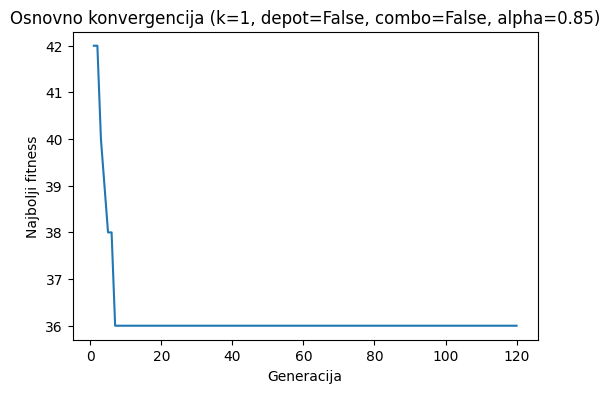

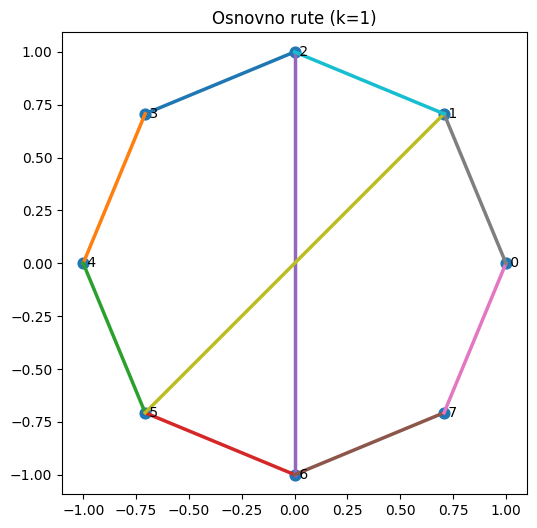

[k=2] fitness=18.000  lengths=18.000, 18.000  time=0.11s


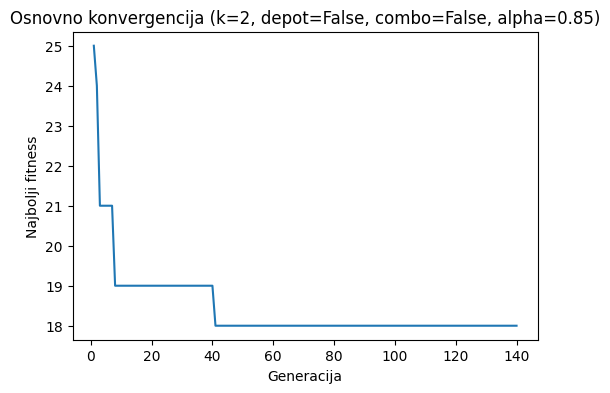

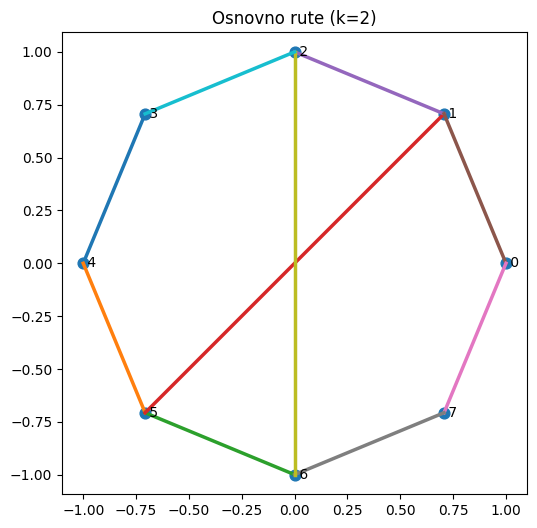

[k=3] fitness=13.000  lengths=12.000, 11.000, 13.000  time=0.12s


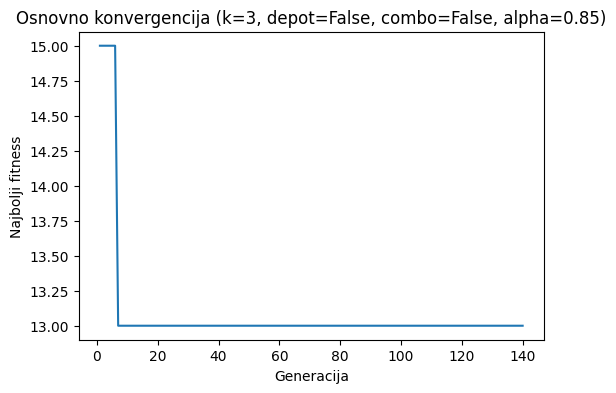

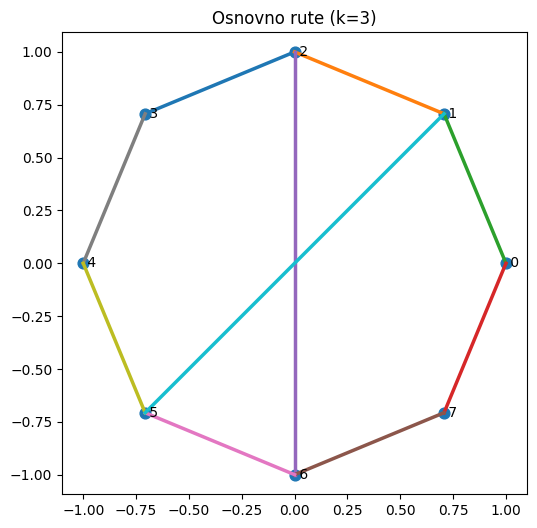


>>> Sa fiksnim depom (depot=0) i kombinovanim fitnessom (alpha=0.85)
[k=2] fitness=20.400  lengths=24.000, 24.000  time=0.31s


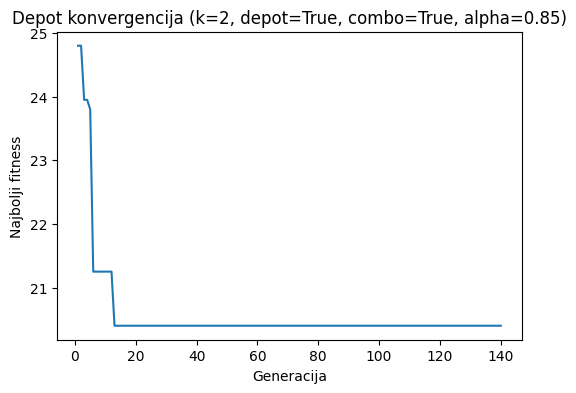

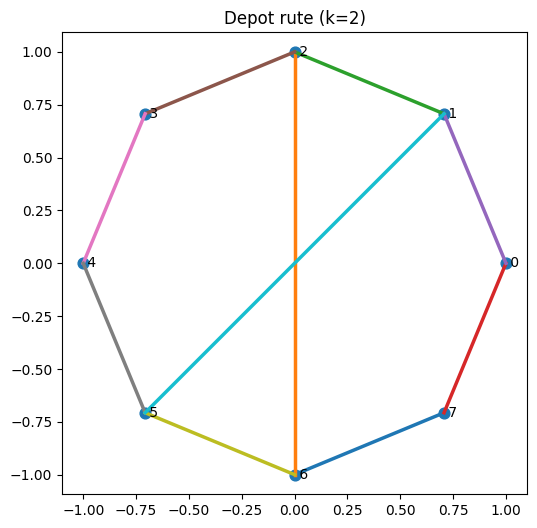

In [9]:
# pokretanje (inline) i crtezi ruta
def run_and_show(g, k, seed, gens, pop, use_depot=False, depot=0, use_combo=False, alpha=0.85, title_prefix=""):
    start = time.time()
    best_ch, best_fit, lens, hist = evolve_ga(g, k=k, gens=gens, pop_size=pop, seed=seed,
                                             use_depot=use_depot, depot=depot,
                                             use_combo=use_combo, alpha=alpha)
    dur = time.time()-start
    print(f"[k={k}] fitness={best_fit:.3f}  lengths={', '.join(f'{x:.3f}' for x in lens)}  time={dur:.2f}s")

    # konvergencija
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(hist)+1), hist)
    plt.xlabel("Generacija"); plt.ylabel("Najbolji fitness")
    plt.title(f"{title_prefix} konvergencija (k={k}, depot={use_depot}, combo={use_combo}, alpha={alpha})")
    plt.show()

    # crtaj rute u boji
    routes = best_ch.to_routes(k)
    draw_graph_with_routes(g, routes, pos=None, title=f"{title_prefix} rute (k={k})")
    return best_ch, best_fit, lens, hist

print(">>> Osnovno: k=1,2,3 bez depota (MinMax)")
_ = run_and_show(g, k=1, seed=1, gens=120, pop=40, use_depot=False, title_prefix="Osnovno")
_ = run_and_show(g, k=2, seed=2, gens=140, pop=50, use_depot=False, title_prefix="Osnovno")
_ = run_and_show(g, k=3, seed=3, gens=140, pop=50, use_depot=False, title_prefix="Osnovno")

print("\n>>> Sa fiksnim depom (depot=0) i kombinovanim fitnessom (alpha=0.85)")
_ = run_and_show(g, k=2, seed=7, gens=140, pop=50, use_depot=True, depot=0, use_combo=True, alpha=0.85, title_prefix="Depot")

Učitan graf (g2): N= 6  M= 7
[k=2] fitness=12.080  lengths=13.000, 13.400  time=0.27s


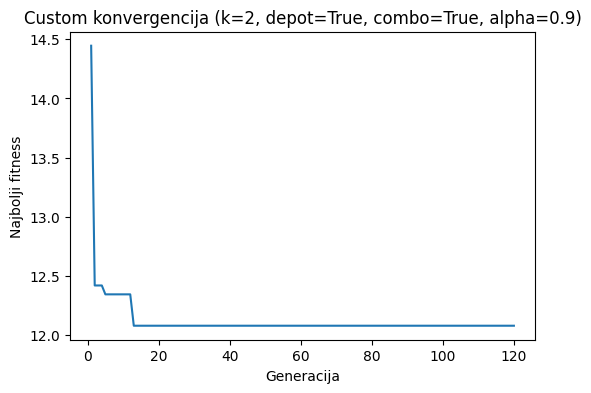

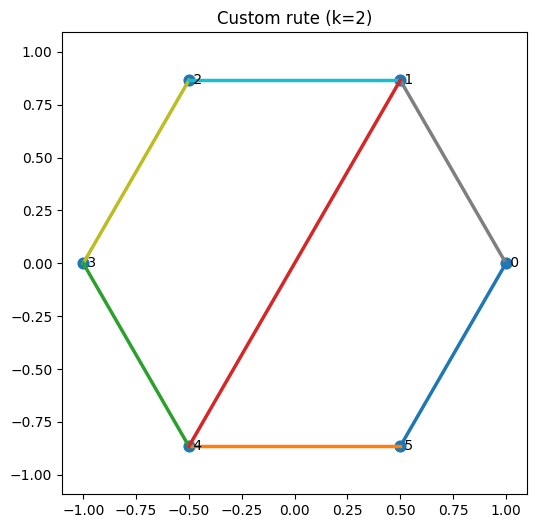

In [10]:
#ucitavanje vlatitog grafa(tekst format) + crtanje
def load_graph_from_text(txt: str) -> UndirectedGraph:
    it = iter(line.strip() for line in txt.strip().splitlines() if line.strip() and not line.strip().startswith("#"))
    first = next(it)
    N, M = map(int, first.split())
    g = UndirectedGraph(N)
    for _ in range(M):
        u, v, w = next(it).split()
        g.add_edge(int(u), int(v), float(w))
    return g

# Primer:
sample_txt = """
# N M
6 7
0 1 2
1 2 3.5
2 3 2
3 4 1.5
4 5 4.2
5 0 3
1 4 2.7
"""
g2 = load_graph_from_text(sample_txt)
print("Učitan graf (g2): N=", g2.n, " M=", len(g2.edges))
_ = run_and_show(g2, k=2, seed=11, gens=120, pop=40, use_depot=True, depot=0, use_combo=True, alpha=0.9, title_prefix="Custom")